예제 2. AutoEncoder 구현하기
==============================
> AutoEncoder를 구축하고 이미지 데이터(Fashion MNIST)를 학습시켜봅시다.


In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [2]:
epochs = 10
batch_size = 256
learning_rate = 0.001

In [3]:
dataset = datasets.FashionMNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [4]:
labels_num = dataset.targets.numpy()
labels = [class_names[i] for i in labels_num]

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Linear(28 * 28, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded) 
        return encoded, decoded

In [6]:
model = Autoencoder().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss() 

In [7]:
loss_list = []
for epoch in tqdm(range(1, epochs+1)):
    loss_value = 0
    for step, (x, label) in enumerate(data_loader):
        model.train()
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device) 
        label = label.to(device)

        encoded, decoded = model(x)

        loss = criterion(decoded, y)
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_value)
    print("Epoch : ", epoch, ', Loss : ', loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  1 , Loss :  0.03575518727302551
Epoch :  2 , Loss :  0.033361706882715225
Epoch :  3 , Loss :  0.03264188393950462
Epoch :  4 , Loss :  0.03457862138748169
Epoch :  5 , Loss :  0.03319167718291283
Epoch :  6 , Loss :  0.02958081290125847
Epoch :  7 , Loss :  0.028171954676508904
Epoch :  8 , Loss :  0.028578316792845726
Epoch :  9 , Loss :  0.0313136950135231
Epoch :  10 , Loss :  0.028191352263092995


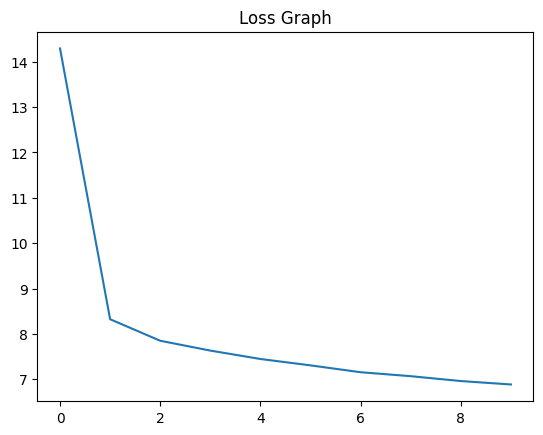

In [8]:
plt.title('Loss Graph')
plt.plot(loss_list)

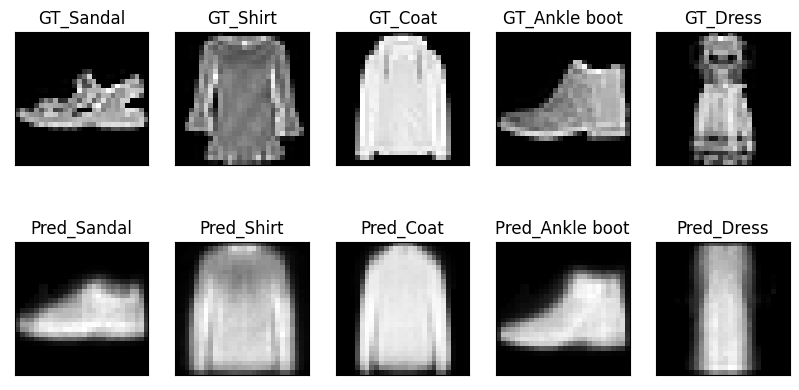

In [10]:
idx = 1111
sample_image = dataset.data[idx:idx+5].view(-1, 28*28)
sample_image = sample_image.type(torch.FloatTensor)/255.
sample_label = dataset.targets[idx:idx+5]

with torch.no_grad():
    model.eval()
    test_image = sample_image.to(device)
    encode_result, decode_result = model(test_image)

f, a = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    img = np.reshape(sample_image.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    a[0][i].set_title('GT_' + class_names[sample_label[i]])

for i in range(5):
    img = np.reshape(decode_result.to("cpu").data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
    a[1][i].set_title('Pred_' + class_names[sample_label[i]])
plt.show()

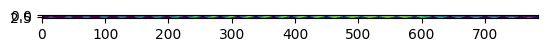

In [21]:
plt.imshow(decode_result.to("cpu").numpy())
plt.show()